Set up tables

In [1]:
import duckdb
conn = duckdb.connect('mydb.duckdb')

# # Drop table if exists
# conn.sql("DROP TABLE IF EXISTS comments")
# conn.sql("DROP TABLE IF EXISTS videos")

# Create 'comments' table from multiple CSVs
conn.sql("""
    CREATE TABLE IF NOT EXISTS comments AS
    SELECT * FROM read_csv_auto('dataset/comments1.csv')
    UNION ALL
    SELECT * FROM read_csv_auto('dataset/comments2.csv')
    UNION ALL
    SELECT * FROM read_csv_auto('dataset/comments3.csv')
    UNION ALL
    SELECT * FROM read_csv_auto('dataset/comments4.csv')
    UNION ALL
    SELECT * FROM read_csv_auto('dataset/comments5.csv')
""")

# Create 'videos' table from videos.csv
conn.sql("""
    CREATE TABLE IF NOT EXISTS videos AS
    SELECT * FROM read_csv_auto('dataset/videos.csv')
""")

Show table columns

In [2]:
# Show all columns for 'comments' and 'videos' tables
print('Comments table columns:')
print(conn.sql('PRAGMA table_info(comments)').df()['name'].tolist())

print('Videos table columns:')
print(conn.sql('PRAGMA table_info(videos)').df()['name'].tolist())

Comments table columns:
['kind', 'commentId', 'channelId', 'videoId', 'authorId', 'textOriginal', 'parentCommentId', 'likeCount', 'publishedAt', 'updatedAt', 'relevance_score']
Videos table columns:
['kind', 'videoId', 'publishedAt', 'channelId', 'title', 'description', 'tags', 'defaultLanguage', 'defaultAudioLanguage', 'contentDuration', 'viewCount', 'likeCount', 'favouriteCount', 'commentCount', 'topicCategories']


Calculate RELEVANCE

In [26]:
video_df = conn.sql('select * from videos').df()
comment_df = conn.sql('select * from comments').df()

In [40]:
video_df

,kind,videoId,publishedAt,channelId,title,description,tags,defaultLanguage,defaultAudioLanguage,contentDuration,viewCount,likeCount,favouriteCount,commentCount,topicCategories
0,youtube#video,85806,2024-01-15 08:59:29+08:00,33807,Unlocking the Benefits of Face Masks for Skin ...,None,None,en-US,en-US,PT9S,72.0,0.0,0.0,0.0,"['https://en.wikipedia.org/wiki/Health', 'http..."
1,youtube#video,30556,2023-10-28 03:32:16+08:00,46650,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,None,None,None,None,PT45S,257.0,7.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
2,youtube#video,51771,2024-09-28 09:23:22+08:00,14346,#trending #makeup #beautymakeup #yslbeauty #lu...,None,None,None,en-US,PT19S,164.0,4.0,0.0,2.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
3,youtube#video,45298,2023-07-13 23:19:28+08:00,50139,#shortvedio #balayage,None,None,None,None,PT14S,1207.0,20.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
4,youtube#video,43611,2023-04-30 02:47:37+08:00,8143,Full Face of Merit Beauty 🤎 featuring new Flus...,None,None,None,en,PT56S,8647.0,268.0,0.0,7.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92754,youtube#video,26001,2023-12-29 05:04:42+08:00,35305,New Year Styling! | #Beachwaver Co.,Connect with us and keep up with our brand! Pl...,"['Beachwaver', 'DreamBigMakeWaves', 'Hair Care...",None,en,PT30S,1485.0,29.0,0.0,0.0,"['https://en.wikipedia.org/wiki/Fashion', 'htt..."
92755,youtube#video,34584,2021-04-15 20:08:32+08:00,6127,DIY glow serum / in urdu and hindi,#shortvideo#\n#youtubeshortvideo#\n#glowserum#,None,None,None,PT31S,24.0,4.0,0.0,0.0,"['https://en.wikipedia.org/wiki/Hobby', 'https..."
92756,youtube#video,21075,2023-04-27 12:07:06+08:00,7271,How Women at 50 Stay Young❓#wrinkles #senescen...,@Jeffree,None,None,None,PT12S,1422.0,10.0,0.0,3.0,"['https://en.wikipedia.org/wiki/Health', 'http..."
92757,youtube#video,44523,2025-04-27 19:16:59+08:00,42969,makeup try #face primer#concealer#faondation,None,None,en-IN,hi,PT22S,75.0,1.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...


In [28]:
# Get the missingness of each column in the videos table
missingness = video_df.isnull().mean() * 100
missingness

kind                     0.000000
videoId                  0.000000
publishedAt              0.000000
channelId                0.000000
title                    0.000000
description             62.012311
tags                    77.478196
defaultLanguage         82.982783
defaultAudioLanguage    67.705560
contentDuration          1.365905
viewCount                1.368061
likeCount                6.607445
favouriteCount           1.365905
commentCount             2.657424
topicCategories          1.650514
dtype: float64

In [8]:
# get missingness for comments table
comment_df.drop(columns=['relevance_score'], inplace=True)
missingness_comments = comment_df.isnull().mean() * 100
missingness_comments

kind                0.000000
commentId           0.000000
channelId           0.000000
videoId             0.000000
authorId            0.000000
textOriginal        0.005439
parentCommentId    89.076536
likeCount           0.000000
publishedAt         0.000000
updatedAt           0.000000
dtype: float64

In [27]:
# Drop specific columns with excessive missingness
video_df_drop_missing_cols = video_df.drop(
    columns=['defaultLanguage', 'tags', 'defaultAudioLanguage']
)

In [33]:
# Fill missing descriptions with a placeholder
video_df_drop_missing_cols['description_imputed'] = video_df_drop_missing_cols['description'].fillna("no_description")

# Create a binary flag for missingness
video_df_drop_missing_cols['description_missing_flag'] = video_df_drop_missing_cols['description'].isna().astype(int)

In [31]:
import pandas as pd

# 1 Convert durations to Timedelta
video_df_drop_missing_cols['duration_td'] = pd.to_timedelta(
    video_df_drop_missing_cols['contentDuration']
)

# 2 Extract total seconds
video_df_drop_missing_cols['duration_seconds'] = (
    video_df_drop_missing_cols['duration_td'].dt.total_seconds()
)

# 3 Create missingness flag before imputation
video_df_drop_missing_cols['duration_missing_flag'] = (
    video_df_drop_missing_cols['duration_seconds'].isna().astype(int)
)

# 4 Compute median for imputation on existing 'duration_seconds'
median_val = video_df_drop_missing_cols['duration_seconds'].median()

# 5 Create a new column or overwrite with imputed values
video_df_drop_missing_cols['duration_seconds_imputed'] = (
    video_df_drop_missing_cols['duration_seconds'].fillna(median_val)
)



In [34]:

# Get the missingness of each column in the new videos table
missingness = video_df_drop_missing_cols.isnull().mean() * 100
missingness

kind                         0.000000
videoId                      0.000000
publishedAt                  0.000000
channelId                    0.000000
title                        0.000000
description                 62.012311
contentDuration              1.365905
viewCount                    1.368061
likeCount                    6.607445
favouriteCount               1.365905
commentCount                 2.657424
topicCategories              1.650514
duration_td                  1.365905
duration_seconds             1.365905
duration_missing_flag        0.000000
duration_seconds_imputed     0.000000
description_imputed          0.000000
description_missing_flag     0.000000
dtype: float64

In [35]:
# get all columns with missing values
missing_columns = video_df_drop_missing_cols.columns[video_df_drop_missing_cols.isnull().any()].tolist()
missing_columns

['description',
 'contentDuration',
 'viewCount',
 'likeCount',
 'favouriteCount',
 'commentCount',
 'topicCategories',
 'duration_td',
 'duration_seconds']

<Axes: >

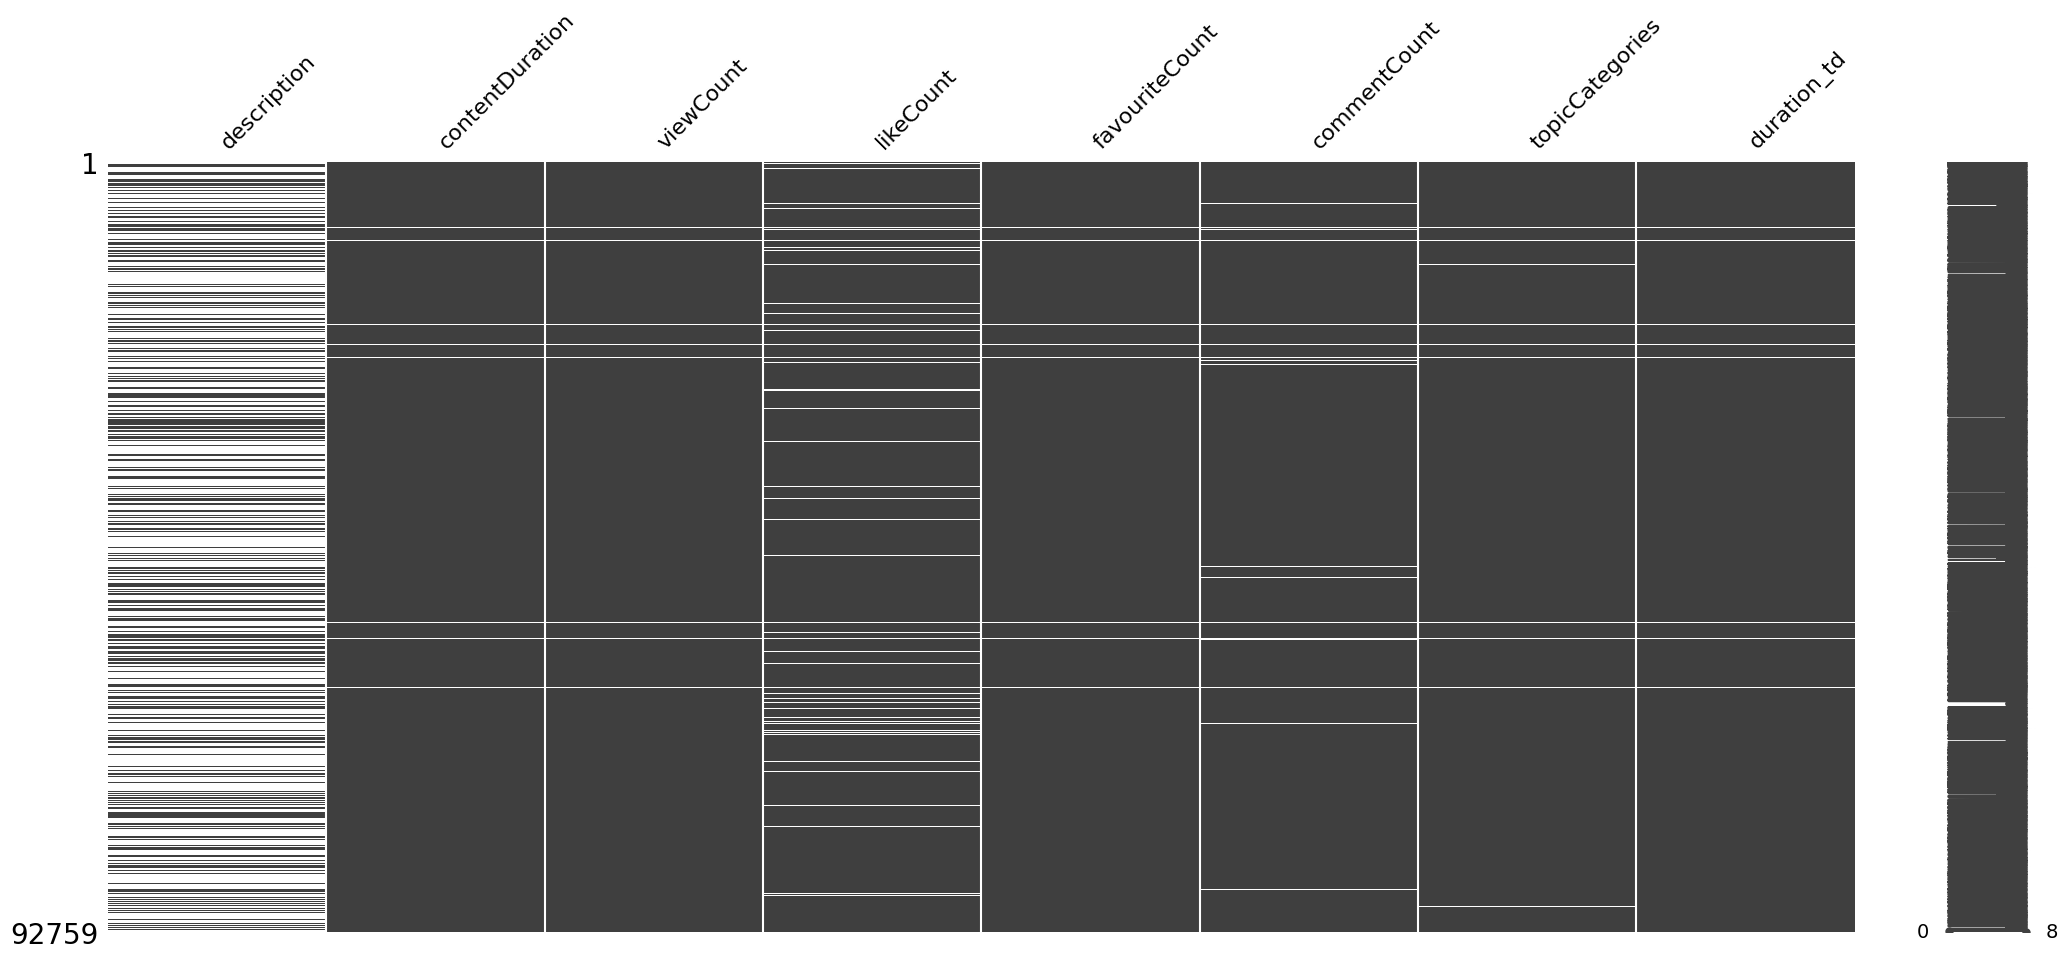

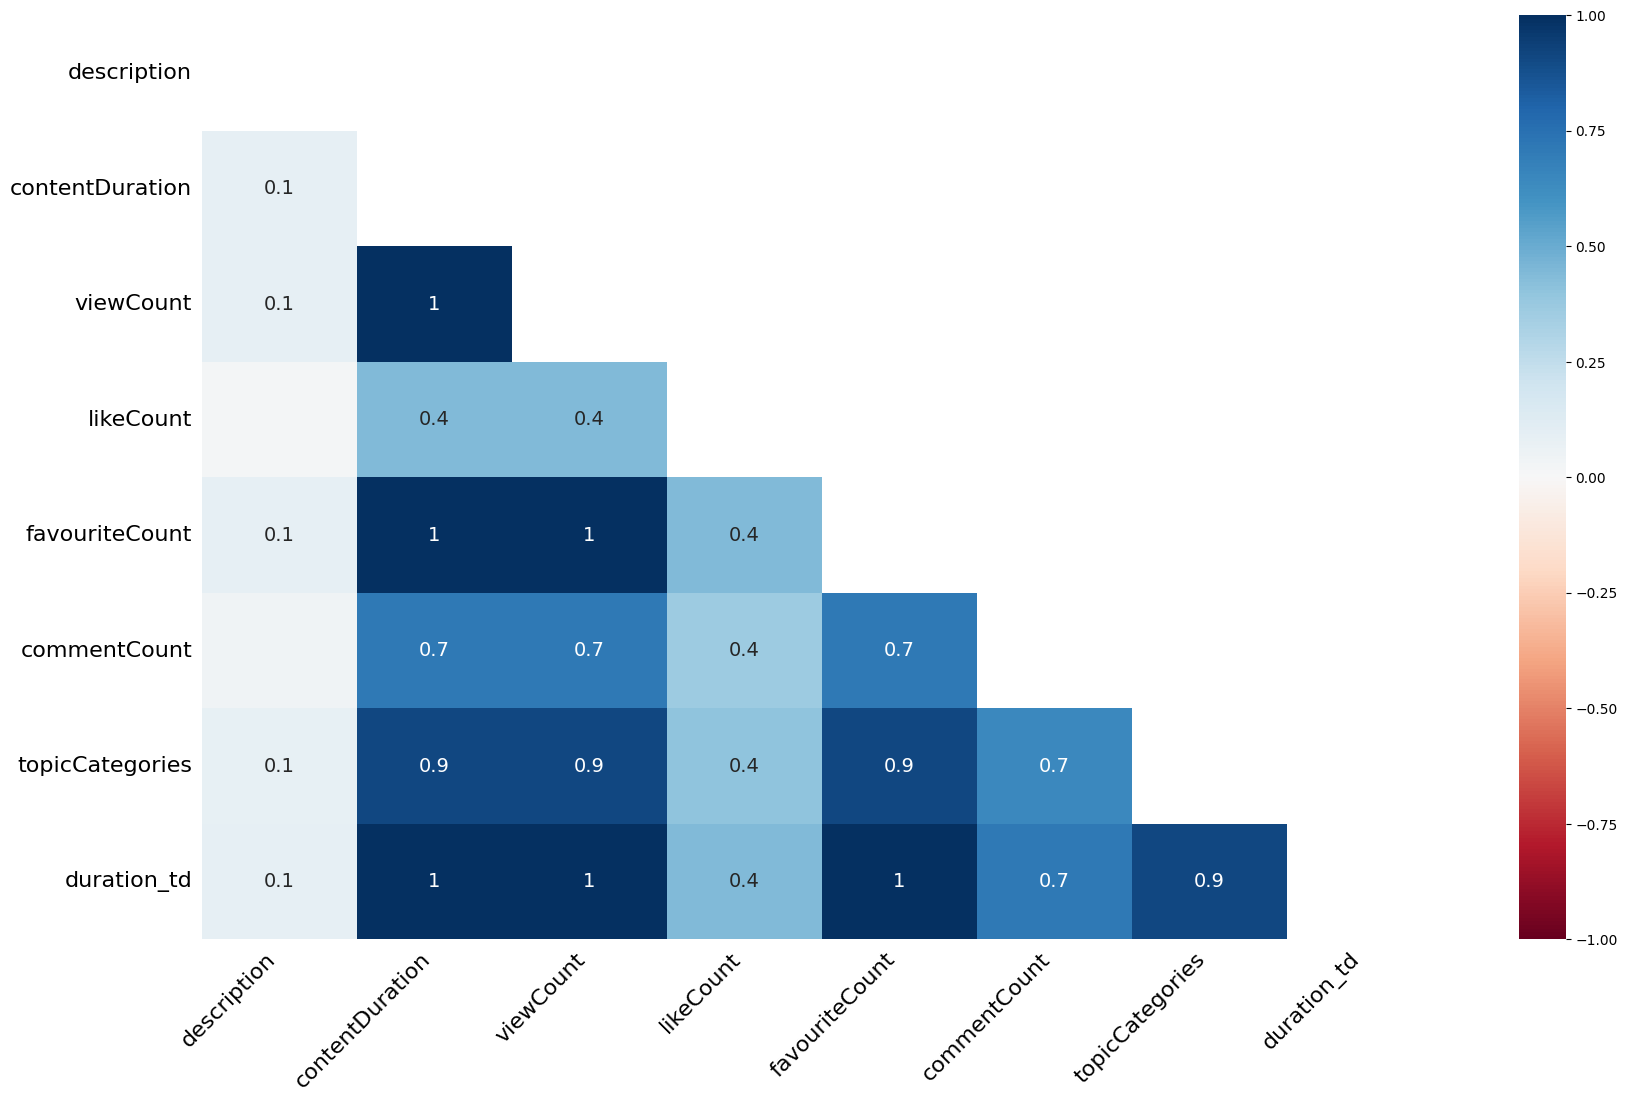

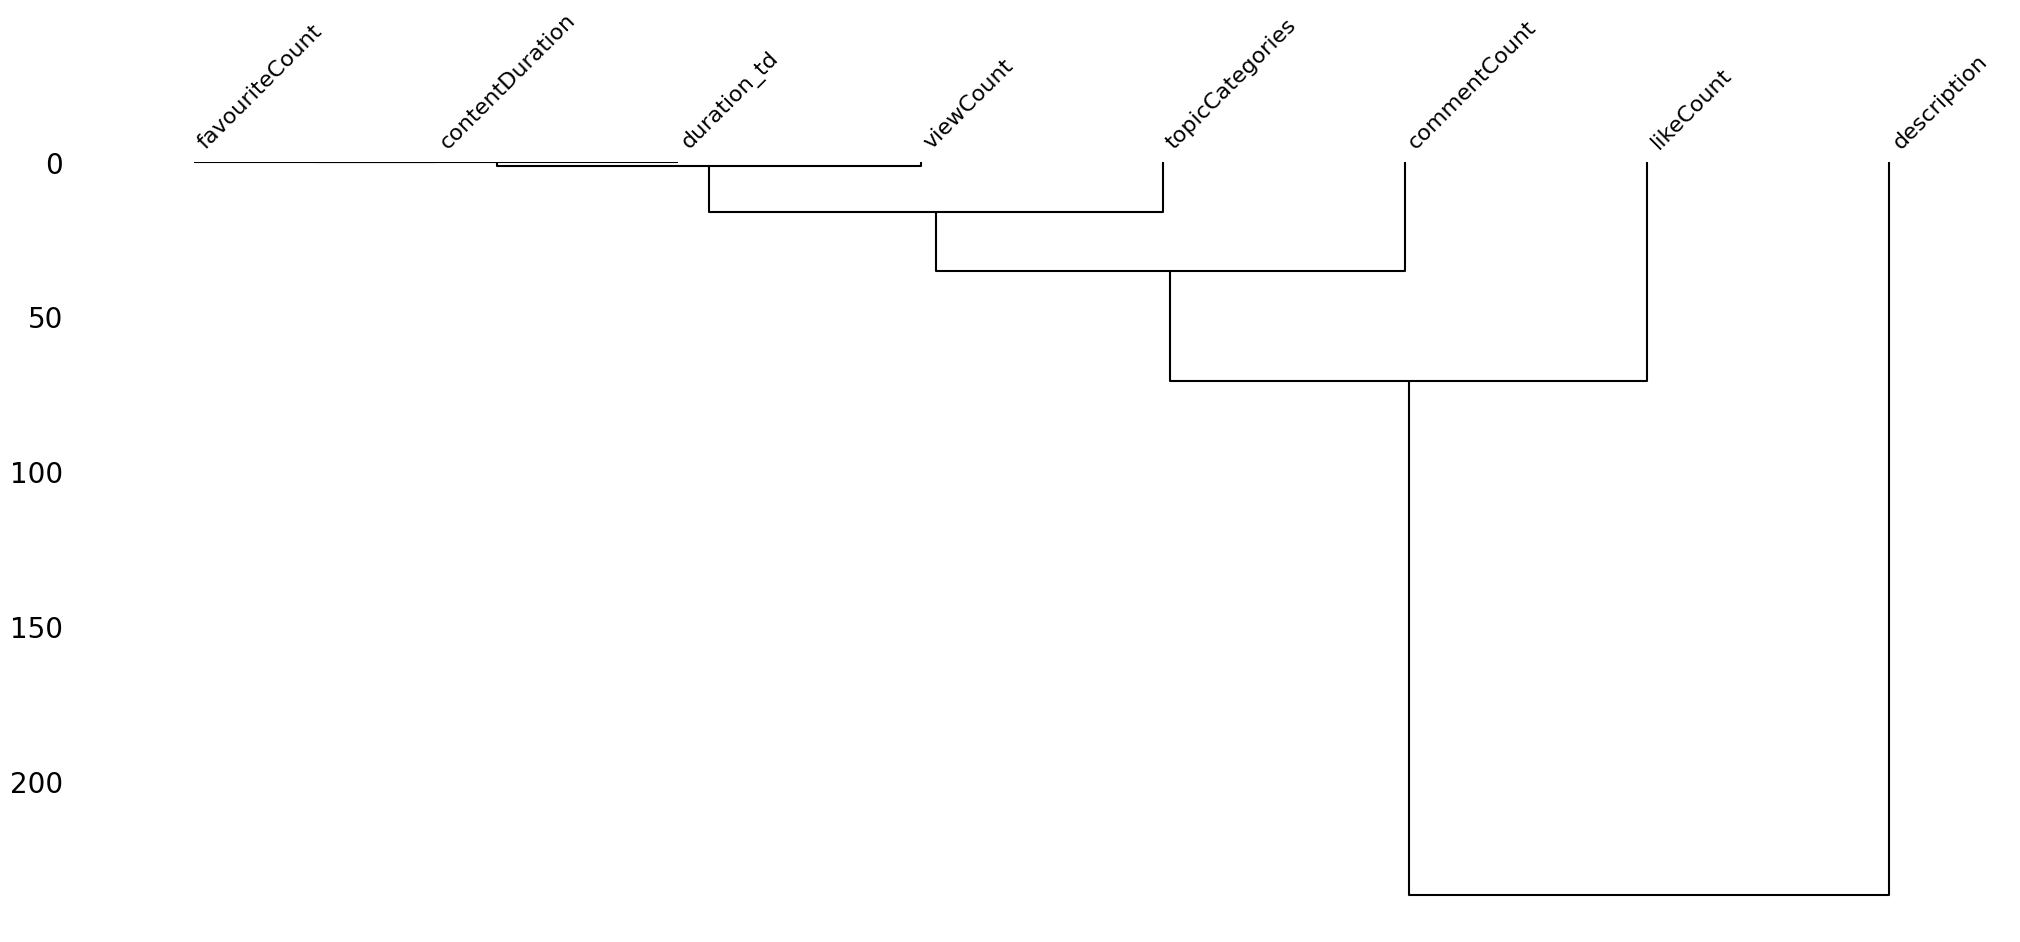

In [25]:
import missingno as msno

# analyze missingness visually

msno.matrix(video_df_drop_missing_cols[missing_columns])
msno.heatmap(video_df_drop_missing_cols[missing_columns])
msno.dendrogram(video_df_drop_missing_cols[missing_columns])

In [54]:
# perform imputation on videos table

# ['description',
#  'contentDuration',
#  'viewCount',
#  'likeCount',
#  'favouriteCount',
#  'commentCount',
#  'topicCategories',
#  'duration_td']

video_df_imputed = video_df_drop_missing_cols.copy()
# 'description' and 'contentDuration' 'duration_td','duration_seconds' are already handled
# Impute numerical columns with median
numerical_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
# use median because of outliers
for col in numerical_cols:
    median_val = video_df_imputed[col].median()
    imputed_col_name = f"{col}_imputed"
    print(f"Imputing {col} with median value {median_val}")
    video_df_imputed[imputed_col_name] = video_df_imputed[col].fillna(median_val)
    missing_flag_col = f"{col}_missing_flag"
    video_df_imputed[missing_flag_col] = video_df_imputed[col].isna().astype(int)





Imputing viewCount with median value 906.0
Imputing likeCount with median value 19.0
Imputing favouriteCount with median value 0.0
Imputing commentCount with median value 0.0


In [75]:
# get the unique values in 'topicCategories'
import ast
import wikipediaapi
from rake_nltk import Rake
import nltk

# Initialize RAKE and Wikipedia client
rake = Rake()
wiki = wikipediaapi.Wikipedia(
    user_agent="LOréalDatathonTool/1.0 (https://github.com/SALeeWenLing/loreal_datathon; mvar0010@student.monash.edu) wikipedia-api/0.8.1",
    language="en"
)

all_titles = set()  # Use a set to automatically discard duplicates

for s in video_df_imputed['topicCategories']:
    if not isinstance(s, str) or not s.strip():
        continue # Skip non-string or empty entries
    try:
        urls = ast.literal_eval(s)
    except (SyntaxError, ValueError):
        continue # Skip malformed entries
    for url in urls:
        title = url.split("/wiki/")[-1] # Extract title from URL
        all_titles.add(title)

# Display the unique titles
for title in sorted(all_titles):
    print(title)

Action-adventure_game
Action_game
Basketball
Business
Casual_game
Country_music
Cricket
Electronic_music
Entertainment
Fashion
Film
Food
Health
Hip_hop_music
Hobby
Humour
Jazz
Knowledge
Lifestyle_(sociology)
Military
Mixed_martial_arts
Music
Music_of_Asia
Music_of_Latin_America
Performing_arts
Pet
Physical_attractiveness
Physical_fitness
Politics
Pop_music
Puzzle_video_game
Religion
Rhythm_and_blues
Role-playing_video_game
Society
Soul_music
Sport
Sports_game
Strategy_video_game
Technology
Television_program
Tennis
Tourism
Vehicle
Video_game_culture


In [67]:
import ssl
import nltk

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrevarilla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andrevarilla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/andrevarilla/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [74]:
import ast
import wikipediaapi
from rake_nltk import Rake
import nltk


title_to_keywords = {}

for title in sorted(all_titles):
    print("Processing Title:", title)
    page = wiki.page(title)
    if page.exists():
        combined_text = page.text
        rake.extract_keywords_from_text(combined_text)
        keywords = rake.get_ranked_phrases()
        title_to_keywords[title] = keywords
        print("  Keywords:", keywords[:5])  # first 5 for brevity
    else:
        title_to_keywords[title] = []
        print("  (No content)")




Processing Title: Action-adventure_game
  Keywords: ['history 1979 – 1988 brett weiss cites atari', 'especially crucial elements like puzzles inspired', 'survival horror survival horror games emphasize', 'references external links media related', 'grand theft auto clone belongs']
Processing Title: Action_game
  Keywords: ['based upon two hong kong martial arts films', 'popular 3d examples include devil may cry', 'action games may sometimes involve puzzle solving', 'driven action games featured large character sprites', 'although newer action games may make use']
Processing Title: Basketball
  Keywords: ['see also basketball moves basketball national league continental basketball association glossary', 'critically acclaimed film hoosiers shows high school basketball', 'new york renaissance five (" rens ")', 'clara gregory baer ), began playing basketball', 'ontario hometown sports heroes archived april 2']
Processing Title: Business
  Keywords: ['see also references == external links ==

In [73]:
keywords_list

[['history 1979 – 1988 brett weiss cites atari',
  'especially crucial elements like puzzles inspired',
  'survival horror survival horror games emphasize',
  'references external links media related',
  'grand theft auto clone belongs',
  'grand theft auto clone',
  'survival horror games share',
  'grand theft auto series',
  'style level building without',
  'share general gameplay dynamics',
  'games like brain breaker',
  'wizardry developer roe r',
  'video games magazine calling',
  'basically arcade games done',
  'others see action games',
  'many different commands introduced',
  'grand theft auto',
  'player several new ways',
  'adventure games normally include',
  '1981 ), castle wolfenstein',
  'adventure gamers may also',
  'adventure game genre tropes',
  'video game hybrid genre',
  'survival horror subgenre',
  '1989 – present',
  'scrolling fantasy games castlevania',
  'resident evil franchise popularized',
  '1985 ), xanadu',
  'games like 005',
  'utilize multiple

In [45]:
# impute 'topicCategories' with a placeholder
video_df_imputed['topicCategories_imputed'] = video_df_imputed['topicCategories'].fillna("no_topic")
video_df_imputed['topicCategories_missing_flag'] = video_df_imputed['topicCategories'].isna().astype(int)


In [46]:
video_df_imputed

,kind,videoId,publishedAt,channelId,title,description,contentDuration,viewCount,likeCount,favouriteCount,...,viewCount_imputed,viewCount_missing_flag,likeCount_imputed,likeCount_missing_flag,favouriteCount_imputed,favouriteCount_missing_flag,commentCount_imputed,commentCount_missing_flag,topicCategories_imputed,topicCategories_missing_flag
0,youtube#video,85806,2024-01-15 08:59:29+08:00,33807,Unlocking the Benefits of Face Masks for Skin ...,None,PT9S,72.0,0.0,0.0,...,72.0,0,0.0,0,0.0,0,0.0,0,"['https://en.wikipedia.org/wiki/Health', 'http...",0
1,youtube#video,30556,2023-10-28 03:32:16+08:00,46650,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,None,PT45S,257.0,7.0,0.0,...,257.0,0,7.0,0,0.0,0,0.0,0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,0
2,youtube#video,51771,2024-09-28 09:23:22+08:00,14346,#trending #makeup #beautymakeup #yslbeauty #lu...,None,PT19S,164.0,4.0,0.0,...,164.0,0,4.0,0,0.0,0,2.0,0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,0
3,youtube#video,45298,2023-07-13 23:19:28+08:00,50139,#shortvedio #balayage,None,PT14S,1207.0,20.0,0.0,...,1207.0,0,20.0,0,0.0,0,0.0,0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,0
4,youtube#video,43611,2023-04-30 02:47:37+08:00,8143,Full Face of Merit Beauty 🤎 featuring new Flus...,None,PT56S,8647.0,268.0,0.0,...,8647.0,0,268.0,0,0.0,0,7.0,0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92754,youtube#video,26001,2023-12-29 05:04:42+08:00,35305,New Year Styling! | #Beachwaver Co.,Connect with us and keep up with our brand! Pl...,PT30S,1485.0,29.0,0.0,...,1485.0,0,29.0,0,0.0,0,0.0,0,"['https://en.wikipedia.org/wiki/Fashion', 'htt...",0
92755,youtube#video,34584,2021-04-15 20:08:32+08:00,6127,DIY glow serum / in urdu and hindi,#shortvideo#\n#youtubeshortvideo#\n#glowserum#,PT31S,24.0,4.0,0.0,...,24.0,0,4.0,0,0.0,0,0.0,0,"['https://en.wikipedia.org/wiki/Hobby', 'https...",0
92756,youtube#video,21075,2023-04-27 12:07:06+08:00,7271,How Women at 50 Stay Young❓#wrinkles #senescen...,@Jeffree,PT12S,1422.0,10.0,0.0,...,1422.0,0,10.0,0,0.0,0,3.0,0,"['https://en.wikipedia.org/wiki/Health', 'http...",0
92757,youtube#video,44523,2025-04-27 19:16:59+08:00,42969,makeup try #face primer#concealer#faondation,None,PT22S,75.0,1.0,0.0,...,75.0,0,1.0,0,0.0,0,0.0,0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,0


In [42]:
# filter out columns that are not needed for relevance score calculation
video_df_imputed.columns

Index(['kind', 'videoId', 'publishedAt', 'channelId', 'title', 'description',
       'contentDuration', 'viewCount', 'likeCount', 'favouriteCount',
       'commentCount', 'topicCategories', 'duration_td', 'duration_seconds',
       'duration_missing_flag', 'duration_seconds_imputed',
       'description_imputed', 'description_missing_flag', 'viewCount_imputed',
       'viewCount_missing_flag', 'likeCount_imputed', 'likeCount_missing_flag',
       'favouriteCount_imputed', 'favouriteCount_missing_flag',
       'commentCount_imputed', 'commentCount_missing_flag'],
      dtype='object')

In [47]:
# drop columns that are not needed for relevance score calculation
video_df_clean = video_df_imputed.drop(columns=[
    'kind', 'description', 'contentDuration', 'viewCount', 'likeCount',
    'favouriteCount', 'commentCount', 'duration_td', 'duration_seconds', 'topicCategories'])

In [48]:
video_df_clean

,videoId,publishedAt,channelId,title,duration_missing_flag,duration_seconds_imputed,description_imputed,description_missing_flag,viewCount_imputed,viewCount_missing_flag,likeCount_imputed,likeCount_missing_flag,favouriteCount_imputed,favouriteCount_missing_flag,commentCount_imputed,commentCount_missing_flag,topicCategories_imputed,topicCategories_missing_flag
0,85806,2024-01-15 08:59:29+08:00,33807,Unlocking the Benefits of Face Masks for Skin ...,0,9.0,no_description,1,72.0,0,0.0,0,0.0,0,0.0,0,"['https://en.wikipedia.org/wiki/Health', 'http...",0
1,30556,2023-10-28 03:32:16+08:00,46650,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,0,45.0,no_description,1,257.0,0,7.0,0,0.0,0,0.0,0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,0
2,51771,2024-09-28 09:23:22+08:00,14346,#trending #makeup #beautymakeup #yslbeauty #lu...,0,19.0,no_description,1,164.0,0,4.0,0,0.0,0,2.0,0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,0
3,45298,2023-07-13 23:19:28+08:00,50139,#shortvedio #balayage,0,14.0,no_description,1,1207.0,0,20.0,0,0.0,0,0.0,0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,0
4,43611,2023-04-30 02:47:37+08:00,8143,Full Face of Merit Beauty 🤎 featuring new Flus...,0,56.0,no_description,1,8647.0,0,268.0,0,0.0,0,7.0,0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92754,26001,2023-12-29 05:04:42+08:00,35305,New Year Styling! | #Beachwaver Co.,0,30.0,Connect with us and keep up with our brand! Pl...,0,1485.0,0,29.0,0,0.0,0,0.0,0,"['https://en.wikipedia.org/wiki/Fashion', 'htt...",0
92755,34584,2021-04-15 20:08:32+08:00,6127,DIY glow serum / in urdu and hindi,0,31.0,#shortvideo#\n#youtubeshortvideo#\n#glowserum#,0,24.0,0,4.0,0,0.0,0,0.0,0,"['https://en.wikipedia.org/wiki/Hobby', 'https...",0
92756,21075,2023-04-27 12:07:06+08:00,7271,How Women at 50 Stay Young❓#wrinkles #senescen...,0,12.0,@Jeffree,0,1422.0,0,10.0,0,0.0,0,3.0,0,"['https://en.wikipedia.org/wiki/Health', 'http...",0
92757,44523,2025-04-27 19:16:59+08:00,42969,makeup try #face primer#concealer#faondation,0,22.0,no_description,1,75.0,0,1.0,0,0.0,0,0.0,0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,0
